# Assignment 8: Deep Q-Networks (Solution)
---

In this assignment, we will solve a classic control problem called Cartpole using OpenAI Gym ([link](https://gym.openai.com/envs/CartPole-v1/)). In particular, we will using the DQN algorithm ([Link](https://openai.com/blog/openai-baselines-dqn/)) to solve the problem.


<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/152690560-12ee45f2-69bb-422c-b230-90e4430f15b3.gif")
"/>
</p>

<p align="center">
  <em>Figure 1: Performance of an untrained agent on Cartpole.</em>
</p>

<br>
<br>


<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/152689694-f72560fd-cbc1-4f55-87fc-c5e21655d667.gif")
"/>
</p>

<p align="center">
  <em>Figure 2: Performance of an agent during training.</em>
</p>






In [ ]:
import time
import gym
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# We are using the Cartpole version 1 environment from OpenAI gym 
env = gym.make("CartPole-v1")

###The CartPole-v1 Evironment 
---

<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/152835304-fa8af20e-d6c5-4b41-b36e-21b1ebe66240.png")
"/>
</p>

<p align="center">
  <em>Figure 3: RL pipeline. </em>
</p>


First, let's get familiar with the terminology of the CartPole-v1 environment.


__Actions:__
  - 0 = Push cart to the left
  - 1 =	Push cart to the right 

__Observations (states):__
  - Cart Position 
  - Cart Velocity 
  - Pole Angle 
  - Pole Velocity at Tip

__Reward:__ 
  - For each timestep that the agent is "not fall," it collects a  reward of `+1`

__Other terminology:__

- Step = agent taking one action in the environment
- Done = flag of the termination of the current episode

<br>

Let's import necessary packages/libraries and specify the environment. 

                    import time
                    import gym
                    import random
                    import numpy as np
                    from collections import deque

                    import tensorflow as tf
                    from tensorflow import keras
                    from keras.models import Sequential
                    from keras.layers import Dense

                    env = gym.make("CartPole-v1")

Next, let's check the values of some variable.  

                    random_action = env.action_space.sample()
                    env.reset()
                    observation, reward, done, info = env.step(random_action)

                    print(f"Action = {random_action}")
                    print(f"Observation = {observation}, shape = {observation.shape}")
                    print(f"Reward = {reward}")
                    print(f"Done = {done}")

                    print(f"Number of actions that can be taken = {env.action_space.n}")
                    print(f"Limits of the observation: \n max ={env.observation_space.low} \n min ={env.observation_space.high}")

In [ ]:
# Sample a random action from action space
random_action = env.action_space.sample()

# reset environment to get started
env.reset()

# apply random action to the environment to get next observation, reward, whether or not eposide is terminated
observation, reward, done, info = env.step(random_action)

# Dimensions , values
print(f"Action = {random_action}")
print(f"Observation = {observation}, shape = {observation.shape}")
print(f"Reward = {reward}")
print(f"Done = {done}")

print(f"Number of actions that can be taken = {env.action_space.n}")
print(f"Limits of the observation: \n max ={env.observation_space.low} \n min ={env.observation_space.high}")

Action = 0
Observation = [-0.03556406 -0.16155895 -0.04809406  0.2835846 ], shape = (4,)
Reward = 1.0
Done = False
Number of actions that can be taken = 2
Limits of the observation: 
 max =[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] 
 min =[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


Next, let's implement two helper functions. 

__1. select_action()__

- The agent can choose either the best action learned so far (exploitation) or a random action (exploration) 
- The exploration rate, which linearly decays from 50% to 2.5%, is used to decide the action

                    def select_action(min_exploration_rate, current_exploration_rate, observation, dqn_agent):
                      rand_num = random.random() 
                      if rand_num <= current_exploration_rate:
                        action = 0 if current_exploration_rate <= min_exploration_rate/2 else 1 
                      else: 
                        action = np.argmax(dqn_agent.predict(observation)[0])
                      return action 

In [ ]:
"""
A function to select actions based on observations
Others inputs required: explioration rate, current model
"""
def select_action(current_exploration_rate, observation, dqn_agent):
  # Enforce that exploration_rate % of actions are taken at random
  # randomly sample a number between 0 and 1
  rand_num = random.random() # Flip a coin
  
  # if the number is less than exploration rate, take random action 
  if rand_num <= current_exploration_rate:
    action = np.random.choice([0,1])  # Take action 0 or 1 with equal probability
    #print(f"Random action = {action}")

  # 100*(1 - exploration_rate) % of the time, take action that the model thinks is best
  else: 
    # Take the max between 2 actions (0 and 1)
    action = np.argmax(dqn_agent.predict(observation)[0])
    #print(f"Learned action = {action}")

  return action 

__2. replay()__

  - The two main features of DQN are the following:
    - Target network: there are two copies of the agent, namely policy network and target network. During training, the target network gets a copy of the policy network every N episodes (set to 10 in this assignment). 

    - Experience replay: store transitions that the agent has taken so far; every episode samples a batch of these transitions to train the agent.


- For every trajectory sampled, a target Q-value is the immediate reward of taking action `a` in state `s` plus the discounted max `Q` value among all possible actions from the successor state `s'`.  The `Q` in the equation below represents the target network. 

<br>

$$Q(s,a) = r(s,a) + \gamma \cdot max_{a} Q(s', a)~~..........~~(Equation~1)$$

<br>

---
## Exercise 1

- In the code snippet below, please implement Equation 1.

- Hints: 
    - $r(s,a) = reward$
    - $\gamma$ is taken as an agrument (gamma) in the function
    - For max operation use the np.amax() from numpy ([link](https://numpy.org/doc/stable/reference/generated/numpy.amax.html))
    - Use `target_agent.predict(observation_next)[0]` to get the Q value

                    def replay(memory, dqn_agent, target_agent, batch_size, gamma):
                      states_batch = [] 
                      q_values_batch = []

                      minibatch = random.sample(memory, batch_size)
                      for current_observation,action, reward, observation_next, done in minibatch: 
                        if not done:
                          target = ############ YOUR CODE HERE ###############
                        else: 
                          target = reward 

                        current_q = dqn_agent.predict(current_observation)
                        current_q[0][action] = target 

                        states_batch.append(current_observation[0])
                        q_values_batch.append(current_q[0]) 

                      states_batch = np.array(states_batch)
                      q_values_batch = np.array(q_values_batch)
                      dqn_agent.fit(states_batch, q_values_batch, epochs=1, verbose=0) 
                      return dqn_agent 

In [ ]:
"""
Train the model on the memory of experiences collected so far
"""
def replay(memory, dqn_agent, target_agent, batch_size, gamma):
  
  states_batch = [] 
  q_values_batch = []

  minibatch = random.sample(memory, batch_size)
  for current_observation,action, reward, observation_next, done in minibatch: 
    
    # Except for the last episode, look into the future
    if not done:
      # target q value = discounted sum of rewards
      target = reward + gamma* np.amax(target_agent.predict(observation_next)[0])
    else: 
      target = reward 

    # The DQN agent outputs q values for all the actions, select the q value for action that is taken
    current_q = dqn_agent.predict(current_observation) # This has 2 q-values (for both the action was taken and not)
    current_q[0][action] = target # update the q value for the action that was taken

    states_batch.append(current_observation[0])
    q_values_batch.append(current_q[0]) # Appending adds one dimension at last

  states_batch = np.array(states_batch)
  q_values_batch = np.array(q_values_batch)

  # Train over a minibatch rather than on single 
  # What do you want the model to learn? (Current observation, updated q value)
  dqn_agent.fit(states_batch, q_values_batch, epochs=1, verbose=0)

  return dqn_agent 

Now, we are going to set some learning parameters. 
                
                    max_episodes = 75 
                    gamma = 0.97 
                    memory = deque(maxlen=256)
                    target_update_steps = 10

                    num_actions = env.action_space.n
                    print(f"Number of actions that can be taken = {num_actions}")
                    num_observations = env.observation_space.shape[0]

                    batch_size = 64
                    learning_rate = 1e-4 #0.0001
                    Adam = keras.optimizers.Adam 

In [ ]:
"""
Set learning parameters
"""
# RL specific parameters
max_episodes = 75 # How many iterations should the learning be done for
gamma = 0.97 # Discount factor
memory = deque(maxlen=256) # Replay memory of specified size
target_update_steps = 10 # update the target network after every 10 episodes

# Environment variables
num_actions = env.action_space.n
print(f"Number of actions that can be taken = {num_actions}")
num_observations = env.observation_space.shape[0]

# Neural network specific paraeters
batch_size = 64
learning_rate = 1e-4#0.0001
Adam = keras.optimizers.Adam 

Number of actions that can be taken = 2




---
## Exercise 2

Our DQN agent uses a 4-layer neural network, which takes the observation as input and output an action for the agent to execute. 

Let's initialize a Sequential model: 

                  dqn_agent = Sequential()

Using `dqn_agent.add()` function to build a DQN agent with the following architecture.
  - Dense layer with `64` output units and `relu` activation, remember to specity `input_dim`
  - Dense layer with `64` output units and `relu` activation
  - Dense layer with `24` output units and `relu` activation
  - Dense layer with `num_actions` output units and `linear` activation

- Compile the `dqn_agent` with `mse` loss and `Adam` optimizer (make sure you specify the `learning_rate`)

- Print the `dqn_agent` model summary
- References 
  - Dense ([link](https://keras.io/api/layers/core_layers/dense/))
  - Compile ([link](https://keras.io/api/models/model_training_apis/))

In [ ]:
"""
Define DQN agent
"""
#Sequential model with 3 Dense layers (Total params = 770)
dqn_agent = Sequential()
dqn_agent.add(Dense(64, input_dim=num_observations, activation="relu"))
dqn_agent.add(Dense(64, activation="relu"))
dqn_agent.add(Dense(24, activation="relu"))
dqn_agent.add(Dense(num_actions, activation="linear")) # Notice that the output has 2 dimensions (why?)

dqn_agent.compile(loss="mse", optimizer= Adam(learning_rate=learning_rate))

dqn_agent.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                320       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 24)                1560      
                                                                 
 dense_7 (Dense)             (None, 2)                 50        
                                                                 
Total params: 6,090
Trainable params: 6,090
Non-trainable params: 0
_________________________________________________________________


Next, let's set the parameters of the following "exponentially decaying $\epsilon$-greedy strategy": 
$$\text{For episode n:}$$
$$ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\text{current exploration probability(%)}~=max[~ϵ_{min}, ~ϵ_{start}(ϵ_{decay~rate})^n] $$

We will start with `100%` exploration and gradually decrease it to `5%`.

                  eps_start = 1.0
                  eps_decay_rate = 0.95
                  eps_min = 0.05

In [ ]:
# Exploration params
eps_start = 1.0
eps_decay_rate = 0.95
eps_min = 0.05 # 5%

---
## Exercise 3

Please fill the missing code in the following main training loop. 

Hints: 

1. __Select action:__ make use of the select_action function defined above
2. __Take a step in the environment:__ make use of the step() function
3. __Gather experience:__ what constitutes a single experience?

                    update_counter = 0 
                    reward_collected = []
                   
                    target_agent = dqn_agent 
                    current_exploration_rate = eps_start 
                    
                    start = time.time()
                    for episode in range(max_episodes): 

                      print(f"Episode {episode}:", end = ' ')
                      current_observation = env.reset().reshape(1,-1) 

                      done = False 
                      score = 0
                      timestep = 0

                      while not done:
                        action = ########## YOUR CODE HERE (1) ##############
                       
                        observation_next , reward, done, info  = ########## YOUR CODE HERE (2) ##############
                        observation_next = observation_next.reshape(1,-1)

                        experience = ########## YOUR CODE HERE (3) ##############
                        memory.append(experience)

                        current_observation = observation_next
                        score += reward
                        timestep+=1 

                      # Out of while loop
                      print(f"Exploration rate = {round(current_exploration_rate,3)},", end = "\t")
                      current_exploration_rate = max(eps_min, current_exploration_rate*eps_decay_rate) 
                      
                      print(f"completed with {timestep} timesteps, score = {score}", end = '\n')
                      reward_collected.append(score)

                      if len(memory) >= batch_size: 
                        dqn_agent  = replay(memory, dqn_agent, target_agent, batch_size, gamma)

                      update_counter+= 1
                      if update_counter% target_update_steps ==0: 
                        target_agent.set_weights(dqn_agent.get_weights()) 

                    env.close()
                    print(f"Total training time taken = {time.time() - start} seconds")

In [ ]:
"""
Main training loop
"""

# Collectors/ counters
update_counter = 0 
reward_collected = []

# Initial values 
target_agent = dqn_agent 
current_exploration_rate = eps_start 

# Start
start = time.time()
for episode in range(max_episodes): 
  print(f"Episode {episode}:", end = ' ')

  # Start each episode by initializing the environment (reset)
  current_observation = env.reset().reshape(1,-1) # Make shape compatible
  done = False 

  # Stats to be collected each episode
  score = 0
  timestep = 0

  # done is True if the agent succeds till the end of timesteps (500) or when the agent fails before that 
  while not done: 
    
    # select an action according to epsilon greedy strategy 
    action = select_action(current_exploration_rate, current_observation, dqn_agent)
    
    # Take a step in the environment
    observation_next , reward, done, info  = env.step(action)
    observation_next = observation_next.reshape(1,-1)

    # Gather the experience and append it o memory 
    experience = (current_observation, action, reward, observation_next, done)
    memory.append(experience)

    # We are done with this timestep, so current observation <-- next observation
    current_observation = observation_next
    score += reward
    timestep+=1 


  # Out of the while loop
  # Print current exploration and update the value to latest using the eqn above
  print(f"Exploration rate = {round(current_exploration_rate,3)},", end = "\t")
  current_exploration_rate = max(eps_min, current_exploration_rate*eps_decay_rate)
  
  print(f"completed with {timestep} timesteps, score = {score}", end = '\n')
  reward_collected.append(score)

  # If we have enough memories collected, Replay the memory of experiences collected so far (to train agent)
  if len(memory) >= batch_size: 
    dqn_agent  = replay(memory, dqn_agent, target_agent, batch_size, gamma)

  update_counter+= 1
  # Copy weights of dqn agent to target agent every target_update_steps
  if update_counter% target_update_steps ==0: 
    target_agent.set_weights(dqn_agent.get_weights()) 

env.close()
print(f"Total training time taken = {time.time() - start} seconds")

Episode 0: Exploration rate = 1.0,	completed with 27 timesteps, score = 27.0
Episode 1: Exploration rate = 0.95,	completed with 16 timesteps, score = 16.0
Episode 2: Exploration rate = 0.902,	completed with 15 timesteps, score = 15.0
Episode 3: Exploration rate = 0.857,	completed with 55 timesteps, score = 55.0
Episode 4: Exploration rate = 0.815,	completed with 23 timesteps, score = 23.0
Episode 5: Exploration rate = 0.774,	completed with 51 timesteps, score = 51.0
Episode 6: Exploration rate = 0.735,	completed with 19 timesteps, score = 19.0
Episode 7: Exploration rate = 0.698,	completed with 39 timesteps, score = 39.0
Episode 8: Exploration rate = 0.663,	completed with 58 timesteps, score = 58.0
Episode 9: Exploration rate = 0.63,	completed with 55 timesteps, score = 55.0
Episode 10: Exploration rate = 0.599,	completed with 48 timesteps, score = 48.0
Episode 11: Exploration rate = 0.569,	completed with 94 timesteps, score = 94.0
Episode 12: Exploration rate = 0.54,	completed with 71

Next, use the code snippet below to plot the learning curve. 

                    fig, ax = plt.subplots(figsize = (8,5))
                    x = len(reward_collected)
                    ax.plot(range(x), reward_collected)
                    ax.set_title(f"Reward Collected over {x} episodes")
                    ax.set_xlabel("Episodes")
                    ax.set_ylabel("Reward per episode")
                    ax.set_xticks(range(0,x+1,10));
                    

<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/153685218-326ad9a1-e6f9-49a8-aab0-358e76bf236e.png")
"/>
</p>

<p align="center">
  <em>Figure 4: Reward plot (Your plot may look different) </em>
</p>



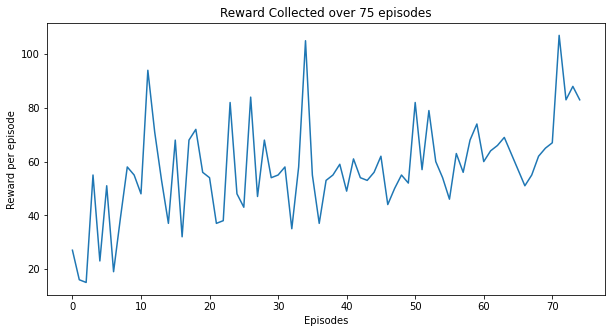

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
x = len(reward_collected)
ax.plot(range(x), reward_collected)
ax.set_title(f"Reward Collected over {x} episodes")
ax.set_xlabel("Episodes")
ax.set_ylabel("Reward per episode")
ax.set_xticks(range(0,x+1,10));

The increase of `reward collected per episode` as the number of episodes progresses implies the agent is learning. 

Now, use the code below to render a rollout of agent performing the task.

Package installation:

                    !pip install gym pyvirtualdisplay > /dev/null 2>&1
                    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
                    !pip install colabgymrender==1.0.2

Rendering code:

                    from colabgymrender.recorder import Recorder 

                    env = gym.make("CartPole-v1")
                    env = Recorder(env, './video')

                    observation = env.reset().reshape(1,-1)
                    done = False
                    while not done:
                      learned_action = np.argmax(dqn_agent.predict(observation)[0])
                      observation, reward, done, info = env.step(learned_action)  
                      observation = observation.reshape(1,-1)
                    env.play()

In [ ]:
# Install some dependencies to record environment render
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [ ]:
from colabgymrender.recorder import Recorder 

env = gym.make("CartPole-v1")
env = Recorder(env, './video')

observation = env.reset().reshape(1,-1)
done = False
while not done:
  # Get best action from agent 
  learned_action = np.argmax(dqn_agent.predict(observation)[0])

  # Apply the best action in the environment
  observation, reward, done, info = env.step(learned_action)  
  observation = observation.reshape(1,-1)
  
env.play()

100%|██████████| 63/63 [00:00<00:00, 375.21it/s]


## Optional: 

Since fully training the agent can take a while. You can instead terminate the training cell above and load an agent that has been trained for 1000 episodes.

Load the agent:

                    !wget -o -q https://github.com/poudel-bibek/Intro-to-AI-Assignments/files/8027697/my_agent.zip
                    !unzip -o -q ./my_agent.zip -d unzipped/ 
                    trained_agent = tf.keras.models.load_model('./unzipped/my_agent')

Using the agent: 

                    env = gym.make("CartPole-v1")
                    env = Recorder(env, './video')

                    observation = env.reset().reshape(1,-1)
                    done = False
                    while not done:
                      # Get best action from agent 
                      learned_action = np.argmax(trained_agent.predict(observation)[0])

                      # Apply the best action in the environment
                      observation, reward, done, info = env.step(learned_action)  
                      observation = observation.reshape(1,-1)
                    env.play()

In [ ]:
"""
get hosted agent that was trained for a really long time
"""

!wget -o -q https://github.com/poudel-bibek/Intro-to-AI-Assignments/files/8046145/my_agent.zip
!unzip -o -q ./my_agent.zip -d unzipped/ 

trained_agent = tf.keras.models.load_model('./unzipped/my_agent_50')

In [ ]:
env = gym.make("CartPole-v1")
env = Recorder(env, './video')

observation = env.reset().reshape(1,-1)
done = False
while not done:
  # Get best action from agent 
  learned_action = np.argmax(trained_agent.predict(observation)[0])

  # Apply the best action in the environment
  observation, reward, done, info = env.step(learned_action)  
  observation = observation.reshape(1,-1)
env.play()

100%|█████████▉| 501/502 [00:01<00:00, 444.25it/s]
